# HaccyTrees

In [1]:
import haccytrees.mergertrees
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from itertools import groupby
from matplotlib.ticker import ScalarFormatter
%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_func_haccytrees

plt.rcParams.update({
    "text.usetex": True,
    #'font.size': 13,
    "figure.figsize": (6.25, 3.75)
})

pyfftw not available, using numpy fft


In [2]:
%%time
forest, progenitor_array = haccytrees.mergertrees.read_forest(
    '/data/a/cpac/mbuehlmann/LastJourney/forest/target_forest_aurora.hdf5',
    'LastJourney', nchunks=1, chunknum=0, mass_threshold = 2.7*10**11,
    include_fields = ["tree_node_mass", "snapnum", "fof_halo_tag", "sod_halo_cdelta", "fof_halo_center_x", "fof_halo_center_y", "fof_halo_center_z"]
)

CPU times: user 7.94 s, sys: 6.76 s, total: 14.7 s
Wall time: 17.5 s


In [3]:
%%time
fg_forest, fg_progenitor_array = haccytrees.mergertrees.read_forest(
    "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest.hdf5",
    'LastJourney',
    mass_threshold=5e11 # Is this for mergers, or "particle size"? (might be the wrong word)
)

CPU times: user 34.2 s, sys: 51.1 s, total: 1min 25s
Wall time: 5min 2s


### Establish Globals

In [5]:
sim = haccytrees.Simulation.simulations['LastJourney']
redshifts = np.flip(sim.step2z(np.array(sim.cosmotools_steps)))
xaxis = 'z_nums'
my_range = [10**13, 10**14]
my_range_str = ["{:.2e}".format(my_range[0]), "{:.2e}".format(my_range[1])]
rangel_bins = [1*10**11, 1.5*10**11, 2.3*10**11, 3.5*10**11, 5.3*10**11, 8.1*10**11, 1.2*10**12, 1.9*10**12, 2.8*10**12, 4.3*10**12, 6.6*10**12, 1*10**13]
rangel_bins2 = np.concatenate(([rangel_bins[0] - 0.25*10**11], [(rangel_bins[i] + rangel_bins[i+1]) / 2 for i in np.arange(len(rangel_bins) -1)], [rangel_bins[-1] + 3.4*10**13]), axis = 0)
# Convert snapshots to redshifts -- opposite order (chronological)
redshifts = np.flip(np.array([10.044, 9.8065, 9.5789, 9.3608, 9.1515, 8.7573, 8.5714, 8.3925, 8.0541, 7.8938, 7.7391, 7.4454, 7.3058, 7.04, 6.9134, 6.6718, 6.5564, 6.3358, 6.1277, 6.028, 5.8367, 5.6556, 5.4839, 5.3208, 5.2422, 5.0909, 4.9467, 4.7429, 4.6145, 4.4918, 4.3743, 4.2618, 4.1015, 4.00, 3.8551, 3.763, 3.6313, 3.5475, 3.4273, 3.3133, 3.205, 3.102, 3.0361, 2.9412, 2.8506, 2.7361, 2.6545, 2.5765, 2.4775, 2.4068, 2.3168, 2.2524, 2.1703, 2.0923, 2.018, 1.9472, 1.8797, 1.7994, 1.7384, 1.68, 1.6104, 1.5443, 1.4938, 1.4334, 1.3759, 1.321, 1.2584, 1.2088, 1.152, 1.1069, 1.0552, 1.006, 0.9591, 0.9143, 0.8646, 0.824, 0.7788, 0.7358, 0.6948, 0.6557, 0.6184, 0.5777, 0.5391, 0.5022, 0.4714, 0.4337, 0.4017, 0.3636, 0.3347, 0.3035, 0.2705, 0.2423, 0.2123, 0.1837, 0.1538, 0.1279, 0.1008, 0.0749, 0.0502, 0.0245, 0.00]))

## Mass Matching - Narrow Bins

In [6]:
# Make masks
fg_masks = help_func_haccytrees.make_masks(fg_forest)
print(len(forest['tree_node_mass'][forest['snapnum'] == 100]))
halo_masks = help_func_haccytrees.make_masks(forest) # Forest should already only contain values in these bins
print(len(halo_masks[0][halo_masks[0]]) + len(halo_masks[1][halo_masks[1]]) + len(halo_masks[2][halo_masks[2]]))

307993
307993


### Find QH Candidates

In [7]:
qh_masks = []
for this_mask in (fg_masks):
    fg_idx = np.nonzero(this_mask)[0]
    mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(fg_idx, fg_forest)
    mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest, fg_progenitor_array, mainbranch_index)
    major_mergers = help_func_haccytrees.get_major_mergers(mainbranch_mergers)
    lmm_redshift = help_func_haccytrees.get_lmms(major_mergers)
    fgs, qhs, mrich = help_func_haccytrees.find_specials(fg_forest, mainbranch_index, major_mergers, lmm_redshift, fg_idx)
    # This qhs index will be an index associated with this specific mass bin/this fg mask. Is there any reason to have a mask version? Maybe, because of later...
    qh_mask = np.zeros_like(this_mask)
    qh_mask[qhs] = 1
    qh_masks.append(qh_mask)

### Testing HaccyTrees 
(go find that cell in the other ntbk if you need -- just remember that there's a quick way to get the mainbhance index if that's all you need, without going through get branches)

## Mass Growth Rates

[array([        0,       380,      1141, ..., 203919799, 203920411,
       203921102]), array([   431902,    432894,    434120, ..., 204025419, 204026299,
       204027138]), array([   516514,    518391,    520611, ..., 204037591, 204039442,
       204041298])]
3
bin n:  0
bin n:  1
bin n:  2


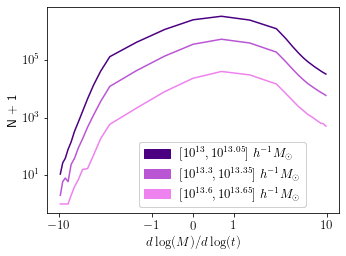

In [18]:
#target_idx = help_func_haccytrees.bin_halos(forest, mbins)
target_idx = [np.nonzero(halo_masks[0])[0], np.nonzero(halo_masks[1])[0], np.nonzero(halo_masks[2])[0]]
colors = iter(["indigo", "mediumorchid", "violet"])
print(target_idx)
print(len(target_idx))
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_binned_branches(target_idx, forest)
alphas = help_func_haccytrees.calc_mass_growth_rate_binned(mainbranch_mass)
bin_labels = [r"$[10^{13}, 10^{13.05}]$ $h^{-1}M_\odot$", r"$[10^{13.3}, 10^{13.35}]$ $h^{-1}M_\odot$", r"$[10^{13.6}, 10^{13.65}]$ $h^{-1}M_\odot$"]
#bin_labels = ["1", "2", "3"]
fig, ax = help_func_haccytrees.plot_mass_growth_rates(alphas, bin_labels = bin_labels, n_hist_bins = 30, zoom = True, log = True, cust_citer = colors) # Why is this so weird? Default should be 10, but 12 looks enormous...
fig.tight_layout() # Why is this throwing an error?
fig.savefig("full_lj_plots/mass_growth_rates.png", bbox_inches='tight', pad_inches=0)

This shape looks much better when we use the `mass_threshold` condition in `read_forest()`! Probably because we don't have so many poorly resolved halos, messing with statistics. (Why would having more poorly resolved halos cause this alpha distribution plot to look different? Specifically, slightly too high on the LHS?) 

## Main Branch Lengths

Can't do this with Rangel Bins currently, because we don't have all those bins (for all the halos)

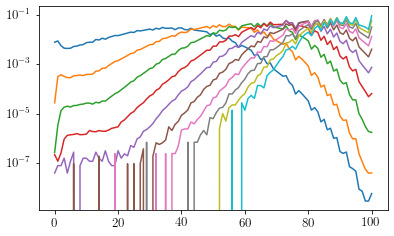

In [110]:
# NEW New way
lengths_bins = np.load('/data/a/cpac/mbuehlmann/LastJourney/forest/z0_mainbranchlength.npz')
#n_halos = np.sum(lengths_bins['bin_counts'])
lengths = np.array([lengths_bins['bin_counts'][i][1:] + lengths_bins['bin_counts'][i+1][1:] + lengths_bins['bin_counts'][i+2][1:] + lengths_bins['bin_counts'][i+3][1:] for i in np.arange(0, 40, 4)])
mass_bins = lengths_bins['mass_bins'][0:-1:4]
n_bins = 32
length_bins = [i*(101/n_bins) for i in np.arange(n_bins + 1)]

# Attempt to create hist bins
#lengths_hist = [[np.sum(lengths[bin_n][i] + lengths[bin_n][i+1] + lengths[bin_n][i+2]) if i + 2 < 101 else np.sum(lengths[bin_n][i] + lengths[bin_n][i+1]) for i in np.arange(0,101,3)] for bin_n in range(len(mass_bins))]

fig, ax = plt.subplots()
for i in range(len(mass_bins)): # Too much hard-coding for my taste...
    n_halos =  np.sum(lengths[i])
    ax.plot(np.arange(0,101), lengths[i]/n_halos) #lengths_hist[i]/n_halos)
    ax.set_yscale('log')
#fig.savefig("full_lj_plots/mainprog_branch_lengths_snapshots.png")

[[5364855 6049272 3898439 ...       2       2       4]
 [   8354   95599  114384 ...      17      12      12]
 [     36     448    1772 ...     406     255     235]
 ...
 [      0       0       0 ...   20146   16537   45828]
 [      0       0       0 ...    8732    7498   24066]
 [      0       0       0 ...    2320    1887    6709]]
[[      4       2       2 ... 3898439 6049272 5364855]
 [     12      12      17 ...  114384   95599    8354]
 [    235     255     406 ...    1772     448      36]
 ...
 [  45828   16537   20146 ...       0       0       0]
 [  24066    7498    8732 ...       0       0       0]
 [   6709    1887    2320 ...       0       0       0]]


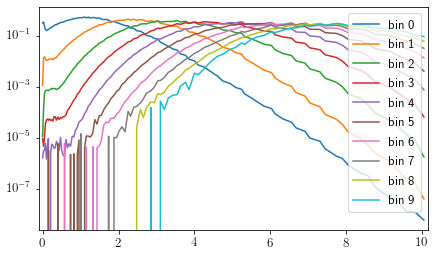

In [31]:
# Same thing, but find at what redshift the halos begin/are first identified
# then find the probability that a halo was "created" between z and z + dz
lengths_bins = np.load('/data/a/cpac/mbuehlmann/LastJourney/forest/z0_mainbranchlength.npz')
lengths = np.array([lengths_bins['bin_counts'][i][1:] + lengths_bins['bin_counts'][i+1][1:] + lengths_bins['bin_counts'][i+2][1:] + lengths_bins['bin_counts'][i+3][1:] for i in np.arange(0, 40, 4)])
print(lengths)
lengths = np.flip(lengths, axis = 1)
print(lengths)

sim = haccytrees.Simulation.simulations['LastJourney']
zsteps = sim.step2z(np.array(sim.cosmotools_steps))
dz = zsteps[:-1] - zsteps[1:] # z_previous - z_current

fig, ax = plt.subplots()
for i in range(len(lengths)): # Too much hard-coding for my taste...
    n_halos =  np.sum(lengths[i])
    smooth_lengths = np.concatenate(([lengths[i][0]], lengths[i][1:]/dz)) # dz's are in the opposite order of my redshifts
    ax.plot(np.flip(redshifts), smooth_lengths/n_halos, label = "bin " + str(i)) #lengths_hist[i]/n_halos)

# Cosmetics
ax.legend()
ax.set_yscale('log')
#ax.set_xscale("symlog", linthresh = 1, linscale = 0.4)
#stepsize = 1
#start, end = ax.get_xlim()
#ax.xaxis.set_ticks(np.arange(0, end, stepsize))
#for axis in [ax.xaxis]:#, ax.yaxis]:
#    axis.set_major_formatter(ScalarFormatter())
ax.margins(x=0.01)
fig.tight_layout()
fig.savefig("full_lj_plots/mainprog_branch_lengths_z.png")

In [26]:
n_bins = 32
length_bins = [i*(101/n_bins) for i in np.arange(n_bins + 1)]
print(length_bins)

[0.0, 3.15625, 6.3125, 9.46875, 12.625, 15.78125, 18.9375, 22.09375, 25.25, 28.40625, 31.5625, 34.71875, 37.875, 41.03125, 44.1875, 47.34375, 50.5, 53.65625, 56.8125, 59.96875, 63.125, 66.28125, 69.4375, 72.59375, 75.75, 78.90625, 82.0625, 85.21875, 88.375, 91.53125, 94.6875, 97.84375, 101.0]


In [24]:
print(len(lengths['mass_bins']), len(lengths['bin_counts']))
print(len(lengths['mass_bins'][0::4]))
print(lengths['mass_bins'][0::4])
my_bins = np.array([lengths['mass_bins'][i] for i in np.arange(0, 40, 4)])
print(len(my_bins))
print(my_bins)

41 40
11
[11.  11.4 11.8 12.2 12.6 13.  13.4 13.8 14.2 14.6 15. ]
10
[11.  11.4 11.8 12.2 12.6 13.  13.4 13.8 14.2 14.6]


In [40]:
#print(lengths['bin_counts'].shape)
#print(lengths['bin_counts'][0])
print(len(lengths['bin_counts'])) # 'mass_bins' 'bin_counts'
my_lengths = [lengths['bin_counts'][i] + lengths['bin_counts'][i+1] + lengths['bin_counts'][i+2] + lengths['bin_counts'][i+3] for i in np.arange(0, 40, 4)]

def plot_main_branch_length(mainbranch_index, n_bins = 32, hist_bins = [], zoom = False, log = True, dist_or_hist = 'dist'):    
# Turn mainbranch_index into a traditional main progenitor list
mp_list = [[[prog_id for prog_id in this_halo if prog_id != -1] for this_halo in np.flip(this_bin_idx)] for this_bin_idx in mainbranch_index]

# Note: assume mp_list is binned
fig, (ax, cax) = plt.subplots(1, 2, figsize=(5, 3), gridspec_kw=dict(wspace=0.03, width_ratios=[1, 0.03])) # check out that figsize
cmap = plt.cm.jet
colors = cmap(np.linspace(0,1,len(my_lengths))) # number of bins, should be 10
color_edges = np.log10(hist_bins) # maybe add some of these together
#tick_edges = [11, 12, 13, 14, 15] #
cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list('blablabla', colors, cmap.N) # requires a name, hence 'blablabla'
norm = plt.matplotlib.colors.BoundaryNorm(color_edges, cmap.N)

length_bins = [i*(101/n_bins) for i in np.arange(n_bins + 1)]

# Loop over each bin
for i in range(len(my_list)):
    current_color = colors[i]
    these_lengths = []

    # Loop over each halo root (don't use this language anymore, lol)
    for j in np.arange(len(mp_list[i])):
        mp_lengths.append(len(mp_list[i][j]))

    if dist_or_hist == 'dist':
        hist, edges = np.histogram(mp_lengths, bins = length_bins)
        bin_centers = ((edges[:-1] + edges[1:]) / 2)
        ax.plot(bin_centers, hist+1, color = current_color)

    elif dist_or_hist == 'hist':
        ax.hist(mp_lengths, bins = n_bins)

if log:
    ax.set_yscale('log')
ax.set_xlabel("length of the main progenitor branch")
ax.set_ylabel("halo count $N + 1$")

cb = plt.matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, ticks=tick_edges, boundaries=color_edges)
cb.set_ticklabels([f'$10^{{{m}}}$' for m in tick_edges])
cb.ax.tick_params(labelsize=10)
cb.set_label('mass bin [$h^{-1}M_\odot$]')

fig.tight_layout()
return fig, ax

40


In [6]:
# New way
#mbins = rangel_bins2
#target_idx = help_func_haccytrees.bin_halos(forest, mbins)
target_idx = [np.nonzero(halo_masks[0])[0], np.nonzero(halo_masks[1])[0], np.nonzero(halo_masks[2])[0]]
xaxis = 'z_nums'
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_binned_branches(target_idx, forest)

In [ ]:
# Takes forever
#fig, ax = help_func_haccytrees.plot_main_branch_length(mainbranch_index, hist_bins = [10**13, 10**13.3, 10**13.6, 10**13.65], log = True)
#fig.savefig("full_lj_plots/main_branch_lengths.png")

Wow! That `mass_threshold` makes a big difference to this plot! (really, it should affect everything up to the yellow branches). Also, the "crossing point" (where the different colors seem to cross each other on the RHS) appears lower, looser, and more spread (to the left)

## Major Merger Stats

#### Single Halo

In [164]:
# Old version
target_idx = 253422
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_branches(target_idx, forest)
absolute_threshold = True
major_mergers_only = True
merger_threshold = 1*10**11.5
mergers, mergers_index, LMM = help_func_haccytrees.get_mergers(forest, progenitor_array, mainbranch_index, absolute_threshold, major_mergers_only, merger_threshold)
print(mergers)
print(mergers_index)
print(LMM)

[3.5869629e+11 8.6413201e+11 3.5254639e+11 4.7633036e+11 2.0516341e+12
 1.4062149e+12]
[253513 253521 253548 253559 253578 253640]
253640


In [166]:
forest['snapnum'][253640]

95

#### Single mass bin

In [176]:
mbins = [1e13, 1e14]
target_idx = help_func_haccytrees.find_halos(forest, mbins)
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_branches(target_idx, forest)

# Now find major mergers
absolute_threshold = True
major_mergers_only = True
merger_threshold = 1*10**11.5
mergers, mergers_index = help_func_haccytrees.get_mergers(forest, progenitor_array, mainbranch_index, absolute_threshold, major_mergers_only, merger_threshold)
print(mergers)
print(mergers_index)

[0. 0. 0. ... 0. 0. 0.]
[3.3423973e+11 2.2880476e+12 4.3944853e+12 ... 9.2663212e+11 1.3280029e+12
 2.9480245e+12]
[    4749     4764     4818 ... 64125678 64125695 64125728]


In [105]:
forest['tree_node_mass'][64125728]

2948024500000.0

#### Multiple bins

In [177]:
absolute_threshold = True
major_mergers_only = True
merger_threshold = 1*10**11.5
mbins = [1e13, 5e13, 1e14, 5e14]
target_idx = help_func_haccytrees.bin_halos(forest, mbins)
mainbranch_binned_index, mainbranch_binned_masses = help_func_haccytrees.get_branches_binned(target_idx, forest, snap = 100)
binned_mergers, binned_mergers_index = help_func_haccytrees.get_mergers_binned(forest, progenitor_array, mainbranch_binned_index, absolute_threshold, major_mergers_only, merger_threshold)

[0. 0. 0. ... 0. 0. 0.]
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.2065274e+11 0.0000000e+00
 0.0000000e+00]
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 1.8882839e+12
 0.0000000e+00]


## LMM Stats

In [263]:
fig.savefig("haccy_pdf_llms_absolute.png")

In [ ]:
z_end = None # In case you want to zoom in
#colors = ["#5D3A9B", "#E66100"] # "#009E73"
color_labels = ["all halos", "FG candidates"]
oranges = ["#CC2200", "#E66100", "#FF8C1A"]
purples = ["#3C1C4A", "#5D3A9B", "#B98CD9"]
greens = ["#00755F", "#00805D"]
colors = iter([oranges, purples, greens])
linestyles = ['--', '-', '-.']
linestyle_labels = [r"$[10^{13}, 10^{13.05}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.3}, 10^{13.35}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.6}, 10^{13.65}]$ $h^{-1}\mathrm{M}_\odot$"]

fig, ax = plt.subplots()
bin_legend_handles = []
for i, (this_mask, catalog, this_progenitor_array) in enumerate(zip([halo_masks, fg_masks, qh_masks], [forest, fg_forest, fg_forest], [progenitor_array, fg_progenitor_array, fg_progenitor_array])):
    
    # Get lmms for all entries in this mask
    this_idx = [np.nonzero(this_mask[0])[0], np.nonzero(this_mask[1])[0], np.nonzero(this_mask[2])[0]]
    mainbranch_index, mainbranch_mass = help_func_haccytrees.get_binned_branches(this_idx, catalog)
    binned_mainbranch_mergers = help_func_haccytrees.get_binned_mainbranch_mergers(catalog, this_progenitor_array, mainbranch_index)
    binned_major_mergers = help_func_haccytrees.get_binned_major_mergers(binned_mainbranch_mergers)
    binned_lmms = help_func_haccytrees.get_binned_lmms(binned_mainbranch_mergers)
    fgs, rugs, mrich = help_func_haccytrees.find_binned_specials(forest, mainbranch_index, binned_major_mergers, binned_lmms, this_idx)
    
    # Loop over each mass bin, plot
    these_colors = next(colors)
    for j, this_bin in enumerate(binned_lmms):
        if i == 2 and j == 2:
            break
        current_color = these_colors[j]
        current_linestyle = linestyles[j]
        current_label = linestyle_labels[j]
        
        # Calculate cdf
        this_bin = this_bin[this_bin >= 0] # Remove any negative values (coming from rugs)
        data_sorted = np.sort(this_bin) # Should automatically sort along the last axis
        hist_keys = np.concatenate(([0] if i == 0 else [1], [key for key, group in groupby(data_sorted)])) # Redshift values
        hist_values = np.concatenate(([0], [len(list(group)) for key, group in groupby(data_sorted)])) # Count of each redshift value
        cum_probs = np.cumsum(hist_values) / len(this_bin)

        if z_end is not None:
            hist_keys = np.append(hist_keys, z_end)
            cum_probs = np.append(cum_probs, cum_probs[-1])

        # Plot cdf
        ax.plot(hist_keys, cum_probs, color = current_color, linestyle = current_linestyle, label = current_label)
        
        if j == 1:
            bin_legend_handles.append(mpatches.Patch(color = current_color, label = color_labels[i])) # For mass bins
    
    # Add legend for mass bins
    if i == 0:
        fake_lines = [ax.plot([],[], linestyle = linestyle, c = 'k')[0] for linestyle in linestyles]
        leg1 = ax.legend(fake_lines, linestyle_labels, loc = 'lower right', frameon = False)
        ax.add_artist(leg1)
        
    # Accessorize
    ax.set_ylabel(r"$p(z_{llm} < z)$")
    ax.set_xlabel(r"Redshift $(z)$")
    ax.set_xscale("symlog", linthresh = 1, linscale = 0.4)
    
    # Unnecessarily Complicated Tick Marks
    stepsize = 1
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(0, end, stepsize))
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())

ax.legend(handles = bin_legend_handles, loc = "center right", frameon = False)
fig.tight_layout()
#fig.savefig("full_lj_plots/cdf_llms.pdf", bbox_inches='tight', pad_inches=0)

#### Cumulative mean number of major mergers

In [ ]:
# Fixing this up
z_end = None # In case you want to zoom in
#colors = ["#5D3A9B", "#E66100"] # "#009E73"

fig, ax = plt.subplots()
bin_legend_handles = []
oranges = ["#CC2200", "#E66100", "#FF8C1A"]
purples = ["#3C1C4A", "#5D3A9B", "#B98CD9"]
colors = iter([oranges, purples])
color_labels = ["all halos", "FG candidates"]
linestyles = ['--', '-', '-.']
linestyle_labels = [r"$[10^{13}, 10^{13.05}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.3}, 10^{13.35}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.6}, 10^{13.65}]$ $h^{-1}\mathrm{M}_\odot$"]

for i, (this_mask, this_catalog, this_progenitor_array) in enumerate(zip([halo_masks, fg_masks], [forest, fg_forest], [progenitor_array, fg_progenitor_array])):
    target_idx = [np.nonzero(this_mask[0])[0], np.nonzero(this_mask[1])[0], np.nonzero(this_mask[2])[0]]
    binned_mainbranch_index, binned_mainbranch_masses = help_func_haccytrees.get_binned_branches(target_idx, this_catalog)
    binned_mainbranch_mergers = help_func_haccytrees.get_binned_mainbranch_mergers(this_catalog, this_progenitor_array, binned_mainbranch_index)
    binned_major_mergers = help_func_haccytrees.get_binned_major_mergers(binned_mainbranch_mergers)
    binned_avg_cum_mms = help_func_haccytrees.calc_binned_avg_cum_mms(binned_major_mergers) # Why did this previously say "long"?
    
    # Loop over mass bins; plot
    these_colors = next(colors) # colors for each fossil status
    for j, this_bin in enumerate(binned_avg_cum_mms):
        current_color = these_colors[j]
        current_linestyle = linestyles[j]
        current_label = linestyle_labels[j]
        ax.plot(redshifts, this_bin, linestyle = current_linestyle, color = current_color, label = current_label)
        
        if j == 1:
            bin_legend_handles.append(mpatches.Patch(color = current_color, label = color_labels[i])) # For mass bins

    # Add legend for mass bins
    if i == 0:
        fake_lines = [ax.plot([],[], linestyle = linestyle, c = 'k')[0] for linestyle in linestyles]
        leg1 = ax.legend(fake_lines, linestyle_labels, loc = 'lower right', frameon = False)
        ax.add_artist(leg1)
    
    # More accessories
    ax.set_xlabel(r"Redshift $(z)$")
    ax.set_ylabel(r"$\langle n_{lm}(z_{lm} < z) \rangle$")
    ax.set_xscale("symlog", linthresh = 1, linscale = 0.4)
    ax.set_yscale('log')
    
    # Unnecessarily Complicated Tick Marks
    stepsize = 1
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(0, end, stepsize))
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())

# Add legend for fossil status
ax.legend(handles = bin_legend_handles, loc = "center right", frameon = False) # Could also have the labels separate from handles, right?
fig.show()
fig.tight_layout()
fig.savefig("full_lj_plots/cum_n_lms.png", bbox_inches='tight', pad_inches=0)

# LLM's Double Panelled Plot:

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in true_divide


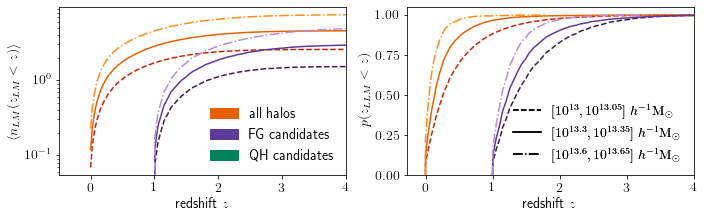

In [8]:
##################
# Cum mean n lms #
##################
plt.rcParams.update({
    'font.size': 14,
})
xright = 4

z_end = None # In case you want to zoom in
#colors = ["#5D3A9B", "#E66100"] # "#009E73"
color_labels = ["all halos", "FG candidates", "QH candidates"]
oranges = ["#CC2200", "#E66100", "#FF8C1A"]
purples = ["#3C1C4A", "#5D3A9B", "#B98CD9"]
greens = ["#00755F", "#00805D", "#00805D"]
colors = [oranges, purples, greens]
linestyles = ['--', '-', '-.']
linestyle_labels = [r"$[10^{13}, 10^{13.05}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.3}, 10^{13.35}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.6}, 10^{13.65}]$ $h^{-1}\mathrm{M}_\odot$"]

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 3.25))
ax = axes[0]
bin_legend_handles = []
for i, (this_mask, this_catalog, this_progenitor_array) in enumerate(zip([halo_masks, fg_masks, qh_masks], [forest, fg_forest, fg_forest], [progenitor_array, fg_progenitor_array, fg_progenitor_array])):
    target_idx = [np.nonzero(this_mask[0])[0], np.nonzero(this_mask[1])[0], np.nonzero(this_mask[2])[0]]
    binned_mainbranch_index, binned_mainbranch_masses = help_func_haccytrees.get_binned_branches(target_idx, this_catalog)
    binned_mainbranch_mergers = help_func_haccytrees.get_binned_mainbranch_mergers(this_catalog, this_progenitor_array, binned_mainbranch_index)
    binned_major_mergers = help_func_haccytrees.get_binned_major_mergers(binned_mainbranch_mergers)
    binned_avg_cum_mms = help_func_haccytrees.calc_binned_avg_cum_mms(binned_major_mergers) # Why did this previously say "long"?
    
    # Loop over mass bins; plot
    these_colors = colors[i] # colors for each fossil status
    for j, this_bin in enumerate(binned_avg_cum_mms):
        if i == 2 and j == 2:
            break
        current_color = these_colors[j]
        current_linestyle = linestyles[j]
        current_label = linestyle_labels[j]
        ax.plot(redshifts, this_bin, linestyle = current_linestyle, color = current_color, label = current_label)
    
        if j == 1:
            bin_legend_handles.append(mpatches.Patch(color = current_color, label = color_labels[i])) # For mass bins

    # More accessories
    ax.set_xlabel(r"redshift $z$")
    ax.set_ylabel(r"$\langle n_{LM}(z_{LM} < z) \rangle$")
    #ax.set_xscale("symlog", linthresh = 1, linscale = 0.4)
    ax.set_yscale('log')
    
    # Unnecessarily Complicated Tick Marks
    #stepsize = 1
    #start, end = ax.get_xlim()
    #end = 5
    #ax.xaxis.set_ticks(np.arange(0, end, stepsize))
    #for axis in [ax.xaxis, ax.yaxis]:
    #    axis.set_major_formatter(ScalarFormatter())
    ax.set_xlim(right = xright)
        
ax.legend(handles = bin_legend_handles, loc = "lower right", frameon = False)
ax.margins(x=0.025)

########################
# Probability of z_LLM #
########################

ax = axes[1]
z_end = None # In case you want to zoom in
#bin_legend_handles = []
for i, (this_mask, catalog, this_progenitor_array) in enumerate(zip([halo_masks, fg_masks, qh_masks], [forest, fg_forest, fg_forest], [progenitor_array, fg_progenitor_array, fg_progenitor_array])):
    
    # Get lmms for all entries in this mask
    this_idx = [np.nonzero(this_mask[0])[0], np.nonzero(this_mask[1])[0], np.nonzero(this_mask[2])[0]]
    mainbranch_index, mainbranch_mass = help_func_haccytrees.get_binned_branches(this_idx, catalog)
    binned_mainbranch_mergers = help_func_haccytrees.get_binned_mainbranch_mergers(catalog, this_progenitor_array, mainbranch_index)
    binned_major_mergers = help_func_haccytrees.get_binned_major_mergers(binned_mainbranch_mergers)
    binned_lmms = help_func_haccytrees.get_binned_lmms(binned_mainbranch_mergers)
    fgs, rugs, mrich = help_func_haccytrees.find_binned_specials(forest, mainbranch_index, binned_major_mergers, binned_lmms, this_idx)
    
    # Loop over each mass bin, plot
    these_colors = colors[i]
    for j, this_bin in enumerate(binned_lmms):
        if i == 2 and j == 2:
            break
        current_color = these_colors[j]
        current_linestyle = linestyles[j]
        current_label = linestyle_labels[j]
        
        # Calculate cdf
        this_bin = this_bin[this_bin >= 0] # Remove any negative values (coming from rugs)
        data_sorted = np.sort(this_bin) # Should automatically sort along the last axis
        hist_keys = np.concatenate(([0] if i == 0 else [1], [key for key, group in groupby(data_sorted)])) # Redshift values
        hist_values = np.concatenate(([0], [len(list(group)) for key, group in groupby(data_sorted)])) # Count of each redshift value
        cum_probs = np.cumsum(hist_values) / len(this_bin)

        if z_end is not None:
            hist_keys = np.append(hist_keys, z_end)
            cum_probs = np.append(cum_probs, cum_probs[-1])

        # Plot cdf
        ax.plot(hist_keys, cum_probs, color = current_color, linestyle = current_linestyle, label = current_label)
                    
    # Add legend for mass bins
    if i == 0:
        fake_lines = [ax.plot([],[], linestyle = linestyle, c = 'k')[0] for linestyle in linestyles]
        leg1 = ax.legend(fake_lines, linestyle_labels, loc = 'lower right', frameon = False)#, fontsize = 13)
        ax.add_artist(leg1)
        
    # Accessorize
    ax.set_ylabel(r"$p(z_{LLM} < z)$")
    ax.set_xlabel(r"redshift $z$")
    #ax.set_xscale("symlog", linthresh = 1, linscale = 0.4)
    
    # Unnecessarily Complicated Tick Marks
    #stepsize = 1
    #start, end = ax.get_xlim()
    #end = 5
    #ax.xaxis.set_ticks(np.arange(0, end, stepsize))
    #for axis in [ax.xaxis, ax.yaxis]:
    #    axis.set_major_formatter(ScalarFormatter()) # Why is this automatically symlog?
    ax.set_xlim(right = xright)
    ax.set_ylim(bottom = 0)

#ax.legend(handles = bin_legend_handles, loc = "center right", bbox_to_anchor = (1, 0.6), frameon = False)

fig.show()
fig.tight_layout()
#fig.savefig("full_lj_plots/lms_llms_lin_zoom.pdf", bbox_inches='tight', pad_inches=0)
# How to extend the right plots down to y = 0?

Notice, none of these plots cross the x-axis. They did in LJSV -- probably because there were fewer groups.

# Fossil Group Stats (!)

### Check overall average mass evolution|

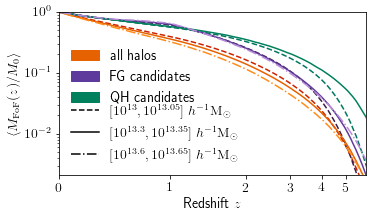

In [13]:
plt.rcParams.update({
    'font.size': 14,
    "figure.figsize": (5.4, 3.25), #(5.2, 3.13), #(5.4, 3.25), #(5.83, 3.5),#(6.25, 4.25), #(6.25, 3.75)
})
# Function version
mass_fractions = True
plot_std = False
xend = 6
bin_labels = [r"$[10^{13}, 10^{13.05}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.3}, 10^{13.35}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.6}, 10^{13.65}]$ $h^{-1}\mathrm{M}_\odot$"]
bins = [[10**13, 10**13.05], [10**13.3, 10**13.35], [10**13.6, 10**13.65]]
fig, ax = plt.subplots()
oranges = ["#CC2200", "#E66100", "#FF8C1A"]
purples = ["#3C1C4A", "#5D3A9B", "#B98CD9"]
greens = ["#00755F", "#00805D", "#00805D"]
linestyles = iter(['--', '-', '-.'])

fake_lines = []
for i, (this_halo_mask, this_fg_mask, this_qh_mask) in enumerate(zip(halo_masks, fg_masks, qh_masks)): # 3
    halo_idx = np.nonzero(this_halo_mask)[0]
    fg_idx = np.nonzero(this_fg_mask)[0]
    qh_idx = np.nonzero(this_qh_mask)[0]
    colors = iter([oranges[i], purples[i], greens[i]])
    current_linestyle = next(linestyles)
    color_labels = ["all halos", "FG candidates", "QH candidates"]
    
    bin_legend_handles = []
    for j, (this_idx, this_catalog) in enumerate(zip([halo_idx, fg_idx, qh_idx], [forest, fg_forest, fg_forest])): # 2
        if i == 2 and j == 2:
            break
        current_color = next(colors)
        current_label = color_labels[j]
        mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(this_idx, this_catalog)
        mainbranch_avg_masses = help_func_haccytrees.avg_mass_bins([mainbranch_masses]) # Can I do this without binning?
        
        for n, this_bin in enumerate(mainbranch_avg_masses): # loop over all bins
            this_bin = this_bin / this_bin[-1] # M(z)/M_0
            ax.plot(np.flip(redshifts), this_bin, color = current_color, linestyle = current_linestyle, label = current_label)
            bin_legend_handles.append(mpatches.Patch(color = current_color, label = current_label)) # For mass bins
            
            if i == 2 and j == 0: # For some reason these don't seem to be making a difference?
                yend = this_bin[np.argmax(np.flip(redshifts) < xend)] # np.argmin gets the first FALSE value, np.argmax gets first TRUE value (?)
                
    if i == 1:
        legend1 = ax.legend(handles = bin_legend_handles, loc = "center left", bbox_to_anchor = (0, 0.6), frameon = False)
        
    fake_lines.append(ax.plot([],[], color = 'k', label=current_label, linestyle = current_linestyle)[0]) # for bins (3)

# Legend
ax.legend(fake_lines, bin_labels, loc = "lower left", frameon = False)
ax.add_artist(legend1)

# Cosmetics
ax.set_xlim(0, xend)
ax.set_ylim(yend, 1) # How can i do this without hardcoding? (want it to go to the y intercept)
ax.set_xscale('symlog', linthresh = 1, linscale = 0.4)
ax.set_yscale('log', nonpositive = 'clip')
ax.set_xlabel(r"Redshift $z$")
ax.set_ylabel(r'$\langle M_{\mathrm{FoF}}(z)/M_0 \rangle$')
ax.xaxis.set_ticks(np.arange(0, xend, 1))
ax.xaxis.set_major_formatter(ScalarFormatter())
fig.tight_layout()
fig.savefig("full_lj_plots/mass_evol_avg_qhs.pdf", bbox_inches='tight', pad_inches=0)

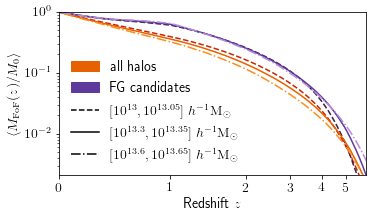

In [12]:
plt.rcParams.update({
    'font.size': 14,
    "figure.figsize": (5.4, 3.25), #(5.2, 3.13), #(5.4, 3.25), #(5.83, 3.5),#(6.25, 4.25), #(6.25, 3.75)
})
# Function version
mass_fractions = True
plot_std = False
xend = 6
bin_labels = [r"$[10^{13}, 10^{13.05}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.3}, 10^{13.35}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.6}, 10^{13.65}]$ $h^{-1}\mathrm{M}_\odot$"]
bins = [[10**13, 10**13.05], [10**13.3, 10**13.35], [10**13.6, 10**13.65]]
fig, ax = plt.subplots()
oranges = ["#CC2200", "#E66100", "#FF8C1A"]
purples = ["#3C1C4A", "#5D3A9B", "#B98CD9"]
linestyles = iter(['--', '-', '-.'])

fake_lines = []
for i, (this_halo_mask, this_fg_mask) in enumerate(zip(halo_masks, fg_masks)): # 3
    halo_idx = np.nonzero(this_halo_mask)[0]
    fg_idx = np.nonzero(this_fg_mask)[0]
    colors = iter([oranges[i], purples[i]])
    current_linestyle = next(linestyles)
    color_labels = ["all halos", "FG candidates"]
    
    bin_legend_handles = []
    for j, (this_idx, this_catalog) in enumerate(zip([halo_idx, fg_idx], [forest, fg_forest])): # 2
        current_color = next(colors)
        current_label = color_labels[j]
        mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(this_idx, this_catalog)
        mainbranch_avg_masses = help_func_haccytrees.avg_mass_bins([mainbranch_masses]) # Can I do this without binning?
        
        for n, this_bin in enumerate(mainbranch_avg_masses): # loop over all bins
            this_bin = this_bin / this_bin[-1] # M(z)/M_0
            ax.plot(np.flip(redshifts), this_bin, color = current_color, linestyle = current_linestyle, label = current_label)
            bin_legend_handles.append(mpatches.Patch(color = current_color, label = current_label)) # For mass bins
            
            if i == 2 and j == 0: # For some reason these don't seem to be making a difference?
                yend = this_bin[np.argmax(np.flip(redshifts) < xend)] # np.argmin gets the first FALSE value, np.argmax gets first TRUE value (?)
                
    if i == 1:
        legend1 = ax.legend(handles = bin_legend_handles, loc = "center left", bbox_to_anchor = (0, 0.6), frameon = False)
        
    fake_lines.append(ax.plot([],[], color = 'k', label=current_label, linestyle = current_linestyle)[0]) # for bins (3)

# Legend
ax.legend(fake_lines, bin_labels, loc = "lower left", frameon = False)
ax.add_artist(legend1)

# Cosmetics
ax.set_xlim(0, xend)
ax.set_ylim(yend, 1) # How can i do this without hardcoding? (want it to go to the y intercept)
ax.set_xscale('symlog', linthresh = 1, linscale = 0.4)
ax.set_yscale('log', nonpositive = 'clip')
ax.set_xlabel(r"Redshift $z$")
ax.set_ylabel(r'$\langle M_{\mathrm{FoF}}(z)/M_0 \rangle$')
ax.xaxis.set_ticks(np.arange(0, xend, 1))
ax.xaxis.set_major_formatter(ScalarFormatter())
fig.tight_layout()
fig.savefig("full_lj_plots/mass_evol_avg.png", bbox_inches='tight', pad_inches=0)

pyfftw not available, using numpy fft
CPU times: user 1.9 s, sys: 318 ms, total: 2.22 s
Wall time: 1.55 s


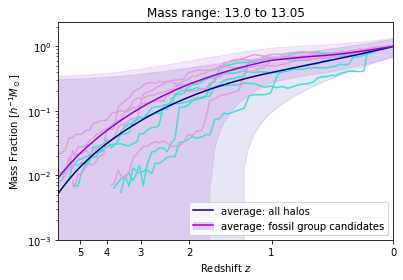

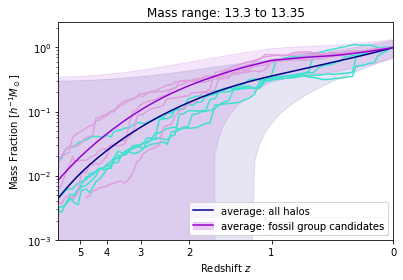

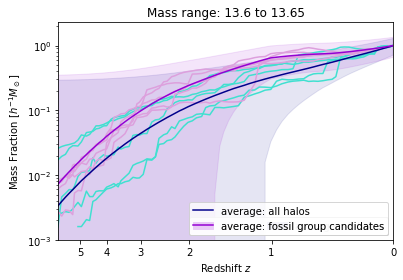

In [50]:
%%time
bin_labels = ["13.0 to 13.05", "13.3 to 13.35", "13.6 to 13.65"]
bins = [[10**13, 10**13.05], [10**13.3, 10**13.35], [10**13.6, 10**13.65]]
for i, (this_halo_mask, this_fg_mask) in enumerate(zip(halo_masks, fg_masks)):
    halo_idx = np.nonzero(this_halo_mask)[0]
    fg_idx = np.nonzero(this_fg_mask)[0]
    nsamples = 5
    ylims = [3*10**10, 10**14]
    fig, ax = help_func_haccytrees.plot_compare_avgs(forest, fg_forest, halo_idx, fg_idx, bins, xend = 6, ylims = None, mass_fractions = True, plot_samples = True, plot_std = True)
    ax.set_title("Mass range: " + bin_labels[i])
    ax.set_ylim(bottom = 10**-3)
    #ax.set_yscale("lin")
    #fig.savefig("full_lj_plots/mass_evol_compare_bin" + str(i) + "_mass_fractions.png")

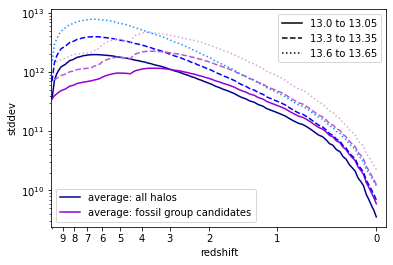

In [25]:
make_relative = False
if make_relative:
    loc1 = "upper left"
    loc2 = "lower right"
else:
    loc1 = "lower left"
    loc2 = "upper right"
bin_labels = ["13.0 to 13.05", "13.3 to 13.35", "13.6 to 13.65"]
timesteps = redshifts # When should I flip and when should I not??
bins = [[10**13, 10**13.05], [10**13.3, 10**13.35], [10**13.6, 10**13.65]]
fig, ax = plt.subplots()
halo_colors = ["darkblue", "blue", "dodgerblue"]
fg_colors = ["darkviolet", "mediumorchid", "plum"]
linestyles = iter(['-', '--', ':'])
fake_lines = []
for i, (this_halo_mask, this_fg_mask) in enumerate(zip(halo_masks, fg_masks)):
    halo_idx = np.nonzero(this_halo_mask)[0]
    fg_idx = np.nonzero(this_fg_mask)[0]
    current_color_list = iter([halo_colors[i], fg_colors[i]])
    current_linestyle = next(linestyles)
    
    labels_for_avgs = iter(["average: all halos", "average: fossil group candidates"])
    for this_idx, this_catalog in zip([halo_idx, fg_idx], [forest, fg_forest]):
        current_color = next(current_color_list)
        current_label = next(labels_for_avgs)
        mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(this_idx, this_catalog)
        mainbranch_avg_masses, variance, stddev = help_func_haccytrees.avg_mass_bins([mainbranch_masses]) # Has some unnecessary binning
        #print("avg masses: ", mainbranch_avg_masses)
        #print("std: ", stddev)
        #print(timesteps)
        if make_relative:
            ax.plot(timesteps, stddev[0]/mainbranch_avg_masses[0], color = current_color, linestyle = current_linestyle, label = current_label)
        else:
            ax.plot(timesteps, stddev[0], color = current_color, linestyle = current_linestyle, label = current_label)
    if i == 0:
        legend1 = ax.legend(loc = loc1)
    fake_lines.append(ax.plot([],[], c='k', linestyle = current_linestyle)[0])
ax.legend(fake_lines, bin_labels, loc = loc2)
ax.add_artist(legend1)
ax.set_xlabel("redshift")
ax.set_yscale('log')
ax.set_xscale("symlog", linthresh = 1, linscale = 0.4)
ax.xaxis.set_ticks(np.arange(0, 10, 1))
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xlim(10.1, -0.1)
if make_relative:
    ax.set_ylabel("stddev / avg_mass")
    #fig.savefig("full_lj_plots/stddev_mass_evols_rel.png")
else:    
    ax.set_ylabel("stddev")
    #fig.savefig("full_lj_plots/stddev_mass_evols.png")

### Major Merger Rates

193417


<ipython-input-166-f0e5fa3cfbbe>:65: RuntimeWarning: invalid value encountered in true_divide
  merger_probability[i] = major_mergers_per_sn / total_halos_per_sn


23256
1736


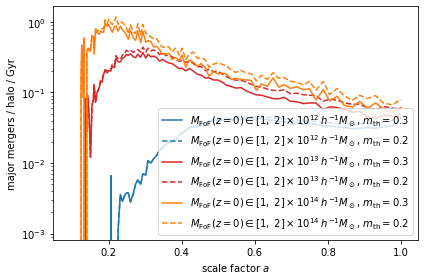

In [166]:
# Define 3 mass-bins
mass_bins = [
    (1e12, 2e12),
    (1e13, 2e13),
    (1e14, 2e14)
]

relative_thresholds = [1/3, 1/4]

# a mask to select all z=0 halos
z0_mask = forest['snapnum'] == 100

# where we will store the merger probability for each mass bin
merger_probability = {} ########## Why this syntax? ##########

for i, mlim in enumerate(mass_bins):
    # creating a target mask for halos at z=0 and in the mass-bin
    target_mask = np.copy(z0_mask)
    target_mask &= (forest['tree_node_mass'] > mlim[0]) 
    target_mask &= (forest['tree_node_mass'] < mlim[1])
    target_idx = forest['halo_index'][target_mask]
    print(len(target_idx))
    
    # Create a matrix of shape (ntargets, nsteps), where each row is the main
    # progenitor branch of a target. It contains the indices to the forest data,
    # and is -1 if the halo does not exist at that time
    mainbranch_index = haccytrees.mergertrees.get_mainbranch_indices(
        forest, simulation='LastJourney', target_index=target_idx
    )
    
    # mask of the matrix elements that are "filled"
    active_mask = mainbranch_index > 0
    
    # For all halos in the matrix, find the main progenitor index and the main merger index
    mainprog_index = haccytrees.mergertrees.get_nth_progenitor_indices(
        forest, progenitor_array, target_index=mainbranch_index[active_mask], n=1
    )
    mainmerger_index = haccytrees.mergertrees.get_nth_progenitor_indices(
        forest, progenitor_array, target_index=mainbranch_index[active_mask], n=2
    )
    
    # Calculate merger ratio at the locations where there are mergers
    # (i.e. where mainmerger_index > 0)
    ###### So we don't make a separate merger_mask, just build that in here ########
    ###### We also don't make a separate matrix of zeros for merger_ratio -- just do a straight division #######
    ###### So, in our other functions, do we need a separate matrix for merger ratio? ########
    ###### actually, a few lines later, we do mess around with active masks too, and also create np.zeros #######
    mainprog_mass   = forest['tree_node_mass'][mainprog_index[mainmerger_index >=0]]
    mainmerger_mass = forest['tree_node_mass'][mainmerger_index[mainmerger_index >= 0]]
    merger_ratio = mainmerger_mass / mainprog_mass
    # Expand it to the "active" part of the matrix
    merger_ratio_active = np.zeros(len(mainprog_index))
    merger_ratio_active[mainmerger_index >= 0] = merger_ratio
    # Expand it to the matrix
    merger_ratio_matrix = np.zeros_like(mainbranch_index, dtype=np.float32)
    merger_ratio_matrix[active_mask] = merger_ratio_active
    
    # The probability for a halo to undergo a major merger at a specific snapshot
    # (along the main progenitor branch)
    total_halos_per_sn = np.sum(active_mask, axis=0)
    major_mergers_per_sn = np.array(
        [np.sum(merger_ratio_matrix > threshold, axis=0) ##### Why axis = 0, and not 1?
            for threshold in relative_thresholds])
    
    merger_probability[i] = major_mergers_per_sn / total_halos_per_sn
    merger_probability[i][:, total_halos_per_sn == 0] = 0   ###### Is this an index, or a mask?
    
    
# Get the scale factors associated with each step (matrix row)
simulation = haccytrees.Simulation.simulations['LastJourney']
scale_factors = simulation.step2a(np.array(simulation.cosmotools_steps))
# Get the time difference between steps in Gyr
lookback_times = simulation.step2lookback(np.array(simulation.cosmotools_steps))
dt = lookback_times[:-1] - lookback_times[1:]

# plotting the major merger probability at every timestep
fig, ax = plt.subplots()
for i, mlim in enumerate(mass_bins):
    for j, rt in enumerate(relative_thresholds):
        # Convert merger rate per snapshot to merger rate per Gyr
        merger_rate = merger_probability[i][j, 1:] / dt
        ax.plot(scale_factors[1:], merger_rate, 
                label=fr"$M_\mathrm{{FoF}}(z=0) \in [1, \; 2] "
                      fr"\times 10^{{{np.log10(mlim[0]):.0f}}} "
                      fr"\; h^{{-1}}M_\odot$, "
                      fr"$m_\mathrm{{th}}={rt:.1f}$",
                color=['tab:blue', 'tab:red', 'tab:orange'][i],
                linestyle=['-', '--'][j])
ax.set(
    yscale='log',
    xlabel='scale factor $a$', 
    ylabel=r'major mergers / halo / Gyr'
)
ax.legend()
fig.tight_layout()